In [205]:
from plotly.offline import init_notebook_mode , plot , iplot 
import pandas as pd
import numpy as np
import plotly.plotly as py
import cufflinks as cf
from datetime import datetime 
import math as m
init_notebook_mode(connected=True)
cf.go_offline()

In [206]:
df = pd.DataFrame({
    'time to maturity' : [0.25, 0.5 , 1 , 1.5 , 2] , 
    'coupon' : [0,0,0,8,12] , 
    'bond price' : [97.5 , 94.9 , 90 , 96 , 101.6]
}) # 資料來源 原文書
'''
設定 Default Info 
'''
df['bond principal'] = 100
df['zero rate %'] = np.zeros(df.shape[0])
df['duration'] = np.zeros(df.shape[0])

def duration(df , fre = 2 ):
    if df['coupon'][i] == 0 :
        return df['time to maturity'][i] 
    else: 
        coupon = df['coupon'][i] / fre
        s = np.zeros(i)
        v = np.zeros(i)
        # 0 , 1 , 2 
        for num in range(i):
            num += 1 
            # 搬公式罷了 ， 前 i-1 個  做 loop save 起來 
            try :
                # 不等於最後一個 ， -1 是因爲最後多出一個 ， 不包含 0 的 shape :
                s[ (num-1) ] = ( df['time to maturity'][num] * coupon * m.exp(-df['zero rate %'][num]/100 * df['time to maturity'][num]) )
                v[ (num-1) ] = ( coupon * m.exp(-df['zero rate %'][num]/100 * df['time to maturity'][num]) )
            except : 
                print('duration not ok')
        return np.sum(s) / np.sum(v)
def zero_coupon(df , i):
    # Coupon 是零的情況下 ， 公式 PV Exp^rt = FV ,
    # where PV = bond price (now) , FV = 100  , r = zero rate % , t = time to maturity 
    try :
        return -(1/df['time to maturity'][i]) * m.log( df['bond price'][i] / df['bond principal'][i] ) * 100
    except Exception : 
        return float('nan')
    
def have_coupon(df , i=3 , fre = 2 ):
    coupon = df['coupon'][i] / fre
    s = np.zeros(i)
    for num in range(i):
        num += 1 
        # 搬公式罷了 ， 前 i-1 個  做 loop save 起來 
        try :
            if num != (i): 
                # 不等於最後一個 ， -1 是因爲最後多出一個 ， 不包含 0 的 shape :
                s[ (num-1) ] = ( coupon * m.exp(-df['zero rate %'][num]/100 * df['time to maturity'][num]) ) 
            elif num == i :
                s[ (num-1) ] = sum(s)
                return -m.log( ( df['bond price'][i] - s[ (num-1) ] ) / (coupon + df['bond principal'][i]) ) / (df['time to maturity'][i]) * 100  
            else : 
                print(i)
        except Exception : 
            return float('nan')
for i in range(df.shape[0]):
    df['duration'][i] = duration(df, fre=2)
    if df['coupon'][i] == 0 :
        df['zero rate %'][i] = zero_coupon(df , i)
    elif df['coupon'][i] != 0 :
        df['zero rate %'][i] = have_coupon(df , i)
    else : 
        break 
        print('error')
df['zero rate'] = df['zero rate %']/100

In [207]:
print(df.head())

   time to maturity  coupon  bond price  bond principal  zero rate %  \
0              0.25       0        97.5             100    10.127123   
1              0.50       0        94.9             100    10.469296   
2              1.00       0        90.0             100    10.536052   
3              1.50       8        96.0             100    10.680926   
4              2.00      12       101.6             100    10.808028   

   duration  zero rate  
0  0.250000   0.101271  
1  0.500000   0.104693  
2  1.000000   0.105361  
3  1.008951   0.106809  
4  1.257090   0.108080  


In [208]:
def svensson_exp_tau(tau,t):  
    return ( 1 - np.exp( -(t / tau) ) ) / ( t / tau)

def svensson_model(b0,b1,b2,b3,tau1,tau2,t):
    svensson = b0 +\
    b1 * svensson_exp_tau(tau1,t) +\
    b2 *( svensson_exp_tau(tau1,t) - np.exp( -(t/tau1) ) ) +\
    b3 *( svensson_exp_tau(tau2,t) - np.exp(-(t/tau2)) )
    return svensson

In [209]:
t = np.arange(0.25,2.25,0.25)
y = svensson_model(0.02, -0.01, -0.01, 0, 2 , 2,t)
df_svensson = pd.DataFrame({'t':{},'y':{}})
n = t.shape[0]
df_svensson['t'] = np.zeros(n)
df_svensson['y'] = np.zeros(n)
num = 0
for i in t:
    df_svensson['t'][num] = i
    num+=1
num = 0
for i in y:
    df_svensson['y'][num] = i
    num+=1
# df_svensson['y'] = df_svensson['y'] *100
# print(df_svensson)
df_svensson.iplot(x = 't' , y = 'y' , yTitle = 'Zero rate %' , xTitle = 'time to maturity' , title = 'Svensson model' , mode = 'markers + lines')

In [210]:
# 暫時性的 設定 
df['svensson spot rate'] = np.zeros(df.shape[0])
df['svensson spot rate'][0] = df_svensson['y'][0]
df['svensson spot rate'][1] = df_svensson['y'][1]
df['svensson spot rate'][2] = df_svensson['y'][3]
df['svensson spot rate'][3] = df_svensson['y'][5]
df['svensson spot rate'][4] = df_svensson['y'][7]

In [211]:
d = df['duration'].sum() # weight bottom
df['w'] = np.zeros(df.shape[0]) 

for i in range(df.shape[0]):
    df['w'][i] = df['duration'][i]/d 
    
print('proof weight equal to one => %s'%df['w'].sum()) #  
df['residual'] = (df['zero rate'] - df['svensson spot rate'])**2
df['w * residual'] = df['residual'] * df['w']

# print(df.head())
print(df['w * residual'].sum())
df[['time to maturity', 'zero rate','svensson spot rate']].iplot(x = 'time to maturity' ,
                                                                 mode = 'markers + lines' ,
                                                                 xTitle = 'time to maturity' , 
                                                                 yTitle = 'model and real diff' 
                                                                )
# 下一步估計 parameters 

proof weight equal to one => 1.0
0.009152044048851442


In [212]:
print(df.head())

   time to maturity  coupon  bond price  bond principal  zero rate %  \
0              0.25       0        97.5             100    10.127123   
1              0.50       0        94.9             100    10.469296   
2              1.00       0        90.0             100    10.536052   
3              1.50       8        96.0             100    10.680926   
4              2.00      12       101.6             100    10.808028   

   duration  zero rate  svensson spot rate         w  residual  w * residual  
0  0.250000   0.101271            0.010024  0.062250  0.008326      0.000518  
1  0.500000   0.104693            0.010092  0.124501  0.008949      0.001114  
2  1.000000   0.105361            0.010327  0.249001  0.009031      0.002249  
3  1.008951   0.106809            0.010653  0.251230  0.009246      0.002323  
4  1.257090   0.108080            0.011036  0.313017  0.009418      0.002948  


In [213]:
# least square 
yi = np.array([df['zero rate']])
ti = np.array([df['time to maturity']])
print(yi[0], ti[0])

[0.10127123 0.10469296 0.10536052 0.10680926 0.10808028] [0.25 0.5  1.   1.5  2.  ]


In [214]:
import matplotlib.pyplot as pt 
from matplotlib import style
style.use('ggplot')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

In [51]:
'''
Try To Log Transformation Base For Data Linearization Does Not Matter
'''
# yii = np.log(1/(yi)) * ti
# pt.plot(ti,yii)

In [215]:
'''
使用 自定參數 svemsson_model 測試資料來編寫模型 預測 參數是否正確
'''
ti = np.arange(0.25,500.25,0.25)
t_b0 , t_b1 , t_b2 , t_b3 ,t_t1 , t_t2 = 0.03 , -0.02 , -0.02 , 0.0 , 2.0 , 2.0  
yi = svensson_model(t_b0 , t_b1 , t_b2 , t_b3 ,t_t1 , t_t2 , ti)

'\n從圖形得知 不是 綫性 linear ， 綫性轉換(using linear transformation)后 預測(previously)能力更不好 \n'

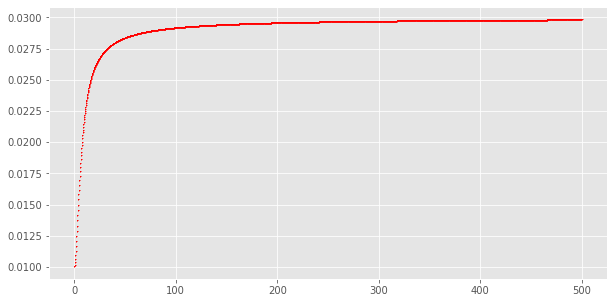

In [216]:
pt.plot(ti,yi,'r+', markersize = 1 )
'''
從圖形得知 不是 綫性 linear ， 綫性轉換(using linear transformation)后 預測(previously)能力更不好 
'''

In [217]:
'''
linear least square
'''
# print(yi)

from scipy.optimize import leastsq
from scipy.optimize import minimize

def svensson_exp_tau(tau,t):  
    return ( 1 - np.exp( -(t / tau) ) ) / ( t / tau)

def n_svensson_model(params, t):
    b0,b1,b2,b3,tau1,tau2 = params 
    svensson = b0 +\
    b1 * svensson_exp_tau(tau1,t) +\
    b2 *( svensson_exp_tau(tau1,t) - np.exp( -(t/tau1) ) ) +\
    b3 *( svensson_exp_tau(tau2,t) - np.exp(-(t/tau2)) )
    return svensson

def error(params , t , y):
    return y - n_svensson_model(params,t)

po = np.array([0.02, -0.01, -0.01, 0, 2 , 2])

params = leastsq(error , po , args=(ti,yi))
# params = minimize( error , po , args=(ti,yi), method='CG')
params = params[0]

b0,b1,b2,b3,tau1,tau2 = params

rn = 2
show = lambda a , b , rn : np.round(np.abs(a - b),rn)  

par = "b0,b1,b2,b3,tau1,tau2".split(',')
p = t_b0 , t_b1 , t_b2 , t_b3 ,t_t1 , t_t2 

print('linear least square method')
print('='*10)
for i in range(po.size) :
    print('參數 %s , 真實 %s , 估計 %s , 差距 %s'%(par[i] , p[i] , np.round(params[i],2) , np.round(np.abs(params[i] - p[i]),2)))
# for loop modifily

linear least square method
參數 b0 , 真實 0.03 , 估計 0.03 , 差距 0.0
參數 b1 , 真實 -0.02 , 估計 -0.02 , 差距 0.0
參數 b2 , 真實 -0.02 , 估計 -0.0 , 差距 0.02
參數 b3 , 真實 0.0 , 估計 -0.02 , 差距 0.02
參數 tau1 , 真實 2.0 , 估計 2.0 , 差距 0.0
參數 tau2 , 真實 2.0 , 估計 2.0 , 差距 0.0


In [220]:
'''
non linear least square 
'''
from scipy.optimize import least_squares

def svensson_exp_tau(tau,t):  
    return ( 1 - np.exp( -(t / tau) ) ) / ( t / tau)

def n_svensson_model(params, t):
    b0,b1,b2,b3,tau1,tau2 = params 
    svensson = b0 +\
    b1 * svensson_exp_tau(tau1,t) +\
    b2 *( svensson_exp_tau(tau1,t) - np.exp( -(t/tau1) ) ) +\
    b3 *( svensson_exp_tau(tau2,t) - np.exp(-(t/tau2)) )
    return svensson

def error(params , t , y):
    return y - n_svensson_model(params,t)

def jac(params, t, yi):
    J = np.empty((t.size, params.size))
    J[:, 0] = 1.0
    J[:, 1] = svensson_exp_tau(params[4],t)
    J[:, 2] = svensson_exp_tau(params[4],t) - np.exp( -(t/params[4]) )
    J[:, 3] = svensson_exp_tau(params[5],t) - np.exp( -(t/params[5]) )
    J[:, 4] = (params[1]/t) * (1 - ( np.exp(-t/params[4]) + np.exp(-t/params[4]) * t / params[4] ) ) + params[2] *  ( ( 1- np.exp(-t/params[4]) )/t - np.exp(-t/params[4]) * (1/params[4] + t/(params[4] **2 )) )
    J[:, 5] = params[3] *  ( ( 1- np.exp(-t/params[5]) )/t - np.exp(-t/params[5]) * (1/params[5] + t/(params[5] **2 )) )
    return J

po = np.array([0.02, -0.01, -0.01, 0.0, 2.0 , 2.0])
t = np.arange(0.25,500.25,0.25)
t_b0 , t_b1 , t_b2 , t_b3 ,t_t1 , t_t2 = 0.03 , -0.02 , -0.02 , 0.0 , 2.0 , 2.0  
yi = svensson_model(t_b0 , t_b1 , t_b2 , t_b3 ,t_t1 , t_t2 , t)

res = least_squares(error, po, jac=jac , args=(t, yi), verbose=1)

par = "b0,b1,b2,b3,tau1,tau2".split(',')
p = t_b0 , t_b1 , t_b2 , t_b3 ,t_t1 , t_t2 
print('non-linear least square method')
print('='*10)
for i in range(po.size) :
    print('參數 %s , 真實 %s , 估計 %s , 差距 %s'%(par[i] , p[i] , res.x[i], np.round(np.abs(res.x[i] - p[i]),2)))
# [ print (res.x) ,  ]  

`xtol` termination condition is satisfied.
Function evaluations 16, initial cost 9.2369e-02, final cost 9.2369e-02, first-order optimality 1.91e+01.
non-linear least square method
參數 b0 , 真實 0.03 , 估計 0.02 , 差距 0.01
參數 b1 , 真實 -0.02 , 估計 -0.01 , 差距 0.01
參數 b2 , 真實 -0.02 , 估計 -0.01 , 差距 0.01
參數 b3 , 真實 0.0 , 估計 0.0 , 差距 0.0
參數 tau1 , 真實 2.0 , 估計 2.0 , 差距 0.0
參數 tau2 , 真實 2.0 , 估計 2.0 , 差距 0.0


In [230]:
'''
non linear 
Conjugate gradient methods (method='CG')
'''
from scipy.optimize import minimize

t_b0 , t_b1 , t_b2 , t_b3 ,t_t1 , t_t2 = 0.03 , -0.02 , -0.02 , 0.0 , 2.0 , 2.0  

po = np.array([0.02, -0.01, -0.01, 0.0, 2.0 , 2.0])
t = np.arange(0.25,500.25,0.25)
y = svensson_model(t_b0 , t_b1 , t_b2 , t_b3 ,t_t1 , t_t2 , t)
res2 = minimize(error, po , jac=jac,args=(t,y),method='CG')
# res2 = least_squares(error, po, jac=jac , args=(t, y), verbose=1)
par = "b0,b1,b2,b3,tau1,tau2".split(',')
p = t_b0 , t_b1 , t_b2 , t_b3 ,t_t1 , t_t2 
print('non-linear conjugate gradient methods')
print('='*10)
for i in range(po.size) :
    print('參數 %s , 真實 %s , 估計 %s , 差距 %s'%(par[i] , p[i] , res2.x[i], np.round(np.abs(res2.x[i] - p[i]),2)))

ValueError: shapes (2000,6) and (2000,6) not aligned: 6 (dim 1) != 2000 (dim 0)

In [182]:
par = "b0,b1,b2,b3,tau1,tau2".split(',')
p = t_b0 , t_b1 , t_b2 , t_b3 ,t_t1 , t_t2 
print('linear least square method')
print('='*10)
for i in range(po.size) :
    print('參數 %s , 真實 %s , 估計 %s , 差距 %s'%(par[i] , p[i] , np.round(params[i],2) , np.round(np.abs(params[i] - p[i]),2)))
print('\n')
print('non-linear conjugate gradient methods')
print('='*10)
for i in range(po.size) :
    print('參數 %s , 真實 %s , 估計 %s , 差距 %s'%(par[i] , p[i] , res2.x[i], np.round(np.abs(res2.x[i] - p[i]),2)))
print('\n')
print('non-linear least square method')
print('='*10)
for i in range(po.size) :
    print('參數 %s , 真實 %s , 估計 %s , 差距 %s'%(par[i] , p[i] , res.x[i], np.round(np.abs(res.x[i] - p[i]),2)))

linear least square method
參數 b0 , 真實 0.03 , 估計 0.03 , 差距 0.0
參數 b1 , 真實 -0.02 , 估計 -0.02 , 差距 0.0
參數 b2 , 真實 -0.02 , 估計 -0.0 , 差距 0.02
參數 b3 , 真實 0.0 , 估計 -0.02 , 差距 0.02
參數 tau1 , 真實 2.0 , 估計 2.0 , 差距 0.0
參數 tau2 , 真實 2.0 , 估計 2.0 , 差距 0.0


non-linear conjugate gradient methods
參數 b0 , 真實 0.03 , 估計 0.02 , 差距 0.01
參數 b1 , 真實 -0.02 , 估計 -0.01 , 差距 0.01
參數 b2 , 真實 -0.02 , 估計 -0.01 , 差距 0.01
參數 b3 , 真實 0.0 , 估計 0.0 , 差距 0.0
參數 tau1 , 真實 2.0 , 估計 2.0 , 差距 0.0
參數 tau2 , 真實 2.0 , 估計 2.0 , 差距 0.0


non-linear least square method
參數 b0 , 真實 0.03 , 估計 0.02 , 差距 0.01
參數 b1 , 真實 -0.02 , 估計 -0.01 , 差距 0.01
參數 b2 , 真實 -0.02 , 估計 -0.01 , 差距 0.01
參數 b3 , 真實 0.0 , 估計 0.0 , 差距 0.0
參數 tau1 , 真實 2.0 , 估計 2.0 , 差距 0.0
參數 tau2 , 真實 2.0 , 估計 2.0 , 差距 0.0


`ftol` termination condition is satisfied.
Function evaluations 131, initial cost 4.4383e+00, final cost 1.5375e-04, first-order optimality 4.52e-08.


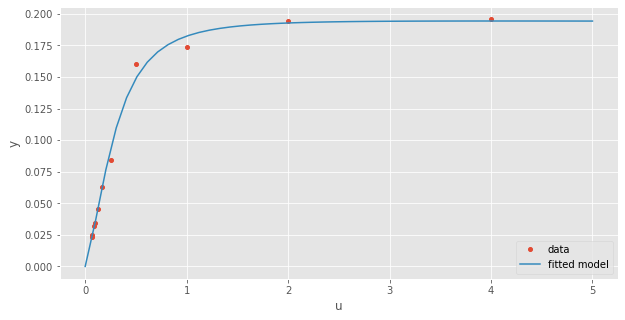

In [153]:
'''
non linear least square example 
from https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#least-squares-minimization-least-squares
'''
from scipy.optimize import least_squares
 
def model(x, u):
    return x[0] * (u ** 2 + x[1] * u) / (u ** 2 + x[2] * u + x[3])
 
def fun(x, u, y):
    return model(x, u) - y
 
def jac(x, u ,y):
    J = np.empty((u.size, x.size))
    den = u ** 2 + x[2] * u + x[3]
    num = u ** 2 + x[1] * u
    J[:, 0] = num / den
    J[:, 1] = x[0] * u / den
    J[:, 2] = -x[0] * num * u / den ** 2
    J[:, 3] = -x[0] * num / den ** 2
    return J
 
u = np.array([4.0, 2.0, 1.0, 5.0e-1, 2.5e-1, 1.67e-1, 1.25e-1, 1.0e-1,
              8.33e-2, 7.14e-2, 6.25e-2])
y = np.array([1.957e-1, 1.947e-1, 1.735e-1, 1.6e-1, 8.44e-2, 6.27e-2,
              4.56e-2, 3.42e-2, 3.23e-2, 2.35e-2, 2.46e-2])
x0 = np.array([2.5, 3.9, 4.15, 3.9])
res = least_squares(fun, x0, jac=jac, bounds=(0, 100), args=(u, y), verbose=1)

res.x
 
import matplotlib.pyplot as plt
u_test = np.linspace(0, 5)
y_test = model(res.x, u_test)
plt.plot(u, y, 'o', markersize=4, label='data')
plt.plot(u_test, y_test, label='fitted model')
plt.xlabel("u")
plt.ylabel("y")
plt.legend(loc='lower right')
plt.show()

In [ ]:
'''
least square method custom
'''
def leastsq(func, x0, args=(), Dfun=None, full_output=0,
            col_deriv=0, ftol=1.49012e-8, xtol=1.49012e-8,
            gtol=0.0, maxfev=0, epsfcn=None, factor=100, diag=None):
    
    x0 = asarray(x0).flatten()
    n = len(x0)
    if not isinstance(args, tuple):
        args = (args,)
    shape, dtype = _check_func('leastsq', 'func', func, x0, args, n)
    m = shape[0]

    if n > m:
        raise TypeError('Improper input: N=%s must not exceed M=%s' % (n, m))
        # overdetermined linear equation
        
    if epsfcn is None:
        epsfcn = finfo(dtype).eps

    if Dfun is None:
        if maxfev == 0:
            maxfev = 200*(n + 1)
        retval = _minpack._lmdif(func, x0, args, full_output, ftol, xtol,
                                 gtol, maxfev, epsfcn, factor, diag)
    else:
        if col_deriv:
            _check_func('leastsq', 'Dfun', Dfun, x0, args, n, (n, m))
        else:
            _check_func('leastsq', 'Dfun', Dfun, x0, args, n, (m, n))
        if maxfev == 0:
            maxfev = 100 * (n + 1)
        retval = _minpack._lmder(func, Dfun, x0, args, full_output,
                                 col_deriv, ftol, xtol, gtol, maxfev,
                                 factor, diag)

    errors = {0: ["Improper input parameters.", TypeError],
              1: ["Both actual and predicted relative reductions "
                  "in the sum of squares\n  are at most %f" % ftol, None],
              2: ["The relative error between two consecutive "
                  "iterates is at most %f" % xtol, None],
              3: ["Both actual and predicted relative reductions in "
                  "the sum of squares\n  are at most %f and the "
                  "relative error between two consecutive "
                  "iterates is at \n  most %f" % (ftol, xtol), None],
              4: ["The cosine of the angle between func(x) and any "
                  "column of the\n  Jacobian is at most %f in "
                  "absolute value" % gtol, None],
              5: ["Number of calls to function has reached "
                  "maxfev = %d." % maxfev, ValueError],
              6: ["ftol=%f is too small, no further reduction "
                  "in the sum of squares\n  is possible.""" % ftol,
                  ValueError],
              7: ["xtol=%f is too small, no further improvement in "
                  "the approximate\n  solution is possible." % xtol,
                  ValueError],
              8: ["gtol=%f is too small, func(x) is orthogonal to the "
                  "columns of\n  the Jacobian to machine "
                  "precision." % gtol, ValueError]}

    # The FORTRAN return value (possible return values are >= 0 and <= 8)
    info = retval[-1]

    if full_output:
        cov_x = None
        if info in LEASTSQ_SUCCESS:
            from numpy.dual import inv
            perm = take(eye(n), retval[1]['ipvt'] - 1, 0)
            r = triu(transpose(retval[1]['fjac'])[:n, :])
            R = dot(r, perm)
            try:
                cov_x = inv(dot(transpose(R), R))
            except (LinAlgError, ValueError):
                pass
        return (retval[0], cov_x) + retval[1:-1] + (errors[info][0], info)
    else:
        if info in LEASTSQ_FAILURE:
            warnings.warn(errors[info][0], RuntimeWarning)
        elif info == 0:
            raise errors[info][1](errors[info][0])
        return retval[0], info